## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft
from scipy.signal.windows import hann
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
# Load and preprocess data
data = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\DP3 Historical Data.csv')
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [3]:
# Select 'Price' column and handle missing values
price_data = df['Price'].astype(float).interpolate()

In [4]:
# Remove outliers (simple Z-score method)
z_scores = np.abs((price_data - price_data.mean()) / price_data.std())
price_data = price_data[z_scores < 3]

In [5]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(price_data.values.reshape(-1, 1))

In [6]:
# Split data
train_size = int(len(data_scaled) * 0.7)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [7]:
# Perform FFT with windowing
def fft_transform(data, num_frequencies=10):
    n = len(data)
    window = hann(n)
    fft_result = fft(data * window)
    frequencies = np.fft.fftfreq(n)
    
    # Keep only top frequencies
    top_indices = np.argsort(np.abs(fft_result))[-num_frequencies:]
    filtered_fft = np.zeros_like(fft_result)
    filtered_fft[top_indices] = fft_result[top_indices]
    
    return filtered_fft, frequencies



In [8]:
# Inverse FFT
def ifft_transform(fft_result):
    return np.real(ifft(fft_result))

In [9]:
# Modify predict_with_trend function
def predict_with_trend(data, fft_result, days, window_size=30):
    # Linear trend
    x = np.arange(window_size)
    trend = np.polyfit(x, data[-window_size:].flatten(), 1)
    trend_func = np.poly1d(trend)
    
    # FFT prediction
    n = len(data)
    if len(fft_result) != n:
        fft_result, _ = fft_transform(data.flatten(), num_frequencies=best_num_freq)
    
    extended_fft = np.zeros(window_size + days, dtype=complex)
    extended_fft[:window_size] = fft_result[-window_size:]
    fft_pred = ifft_transform(extended_fft)[-days:]
    
    # Combine trend and FFT
    trend_pred = trend_func(np.arange(window_size, window_size+days))
    combined_pred = trend_pred + fft_pred
    return np.maximum(combined_pred, 0)  # Ensure non-negative values

In [10]:
# Optimize number of frequencies
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_num_freq = 0

for num_freq in range(5, 51, 5):
    mse_scores = []
    for train_index, val_index in tscv.split(train_data):
        train_subset = train_data[train_index]
        val_subset = train_data[val_index]
        
        train_fft, _ = fft_transform(train_subset.flatten(), num_frequencies=num_freq)
        pred = predict_with_trend(train_subset, train_fft, len(val_subset))
        mse = mean_squared_error(val_subset, pred)
        mse_scores.append(mse)
    
    avg_mse = np.mean(mse_scores)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_num_freq = num_freq

print(f"Best number of frequencies: {best_num_freq}")


Best number of frequencies: 5


In [11]:
# Recompute FFT with best number of frequencies
train_fft, _ = fft_transform(train_data.flatten(), num_frequencies=best_num_freq)

In [12]:
# Predict for test data using sliding window
window_size = 30
step_size = 7
filtered_test = []

for i in range(0, len(test_data), step_size):
    if i + window_size > len(train_data):
        break
    window_data = np.concatenate((train_data[-window_size:], test_data[:i]))
    window_fft, _ = fft_transform(window_data.flatten(), num_frequencies=best_num_freq)
    pred = predict_with_trend(window_data, window_fft, step_size, window_size)
    filtered_test.extend(pred)

filtered_test = np.array(filtered_test)[:len(test_data)]

In [13]:
# Predict future values
future_data = np.concatenate((train_data, test_data))
future_fft, _ = fft_transform(future_data.flatten(), num_frequencies=best_num_freq)
y_next_30_days = predict_with_trend(future_data, future_fft, 30, window_size)
y_next_60_days = predict_with_trend(future_data, future_fft, 60, window_size)
y_next_90_days = predict_with_trend(future_data, future_fft, 90, window_size)

In [14]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(test_data, filtered_test.reshape(-1, 1))
test_mse = mean_squared_error(test_data, filtered_test.reshape(-1, 1))
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_data, filtered_test.reshape(-1, 1))

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 0.612787924271218
RMSE on Test set: 0.20762169526686708
MSLE on Test set: 0.023215633073383753


In [15]:
# Inverse transform predictions
filtered_test = scaler.inverse_transform(filtered_test.reshape(-1, 1)).flatten()
y_next_30_days = scaler.inverse_transform(y_next_30_days.reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(y_next_60_days.reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(y_next_90_days.reshape(-1, 1)).flatten()

# Print predictions
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)

Predicted next 30 days:
[576740.2391666   31310.         500746.84731884  31310.
 389006.4881942   31310.         255369.05881975  31310.
 115929.22345233  65175.916097    31310.         183303.91351553
  31310.         273120.97596835  31310.         328628.88221188
  31310.         349621.26785614  31310.         341305.01539759
  31310.         313009.89211809  31310.         276226.59800965
  31310.         242327.7051354   31310.         220378.32987946
  31310.         215424.83483657]

Predicted next 60 days:
[218132.93972511  31310.         181059.36446332 300863.6710821
  31310.          88348.65792952 367745.134736    31310.
  31310.         409893.79664837  31310.          31310.
 421441.97943416  31310.          31310.         400484.60636072
  31310.          31310.         349398.83752785 120128.16524679
  31310.         274481.75717705 210209.36045433  31310.
 184966.62999305 280676.97019436  31310.          91583.23214706
 325244.66512211  31310.          31310.        

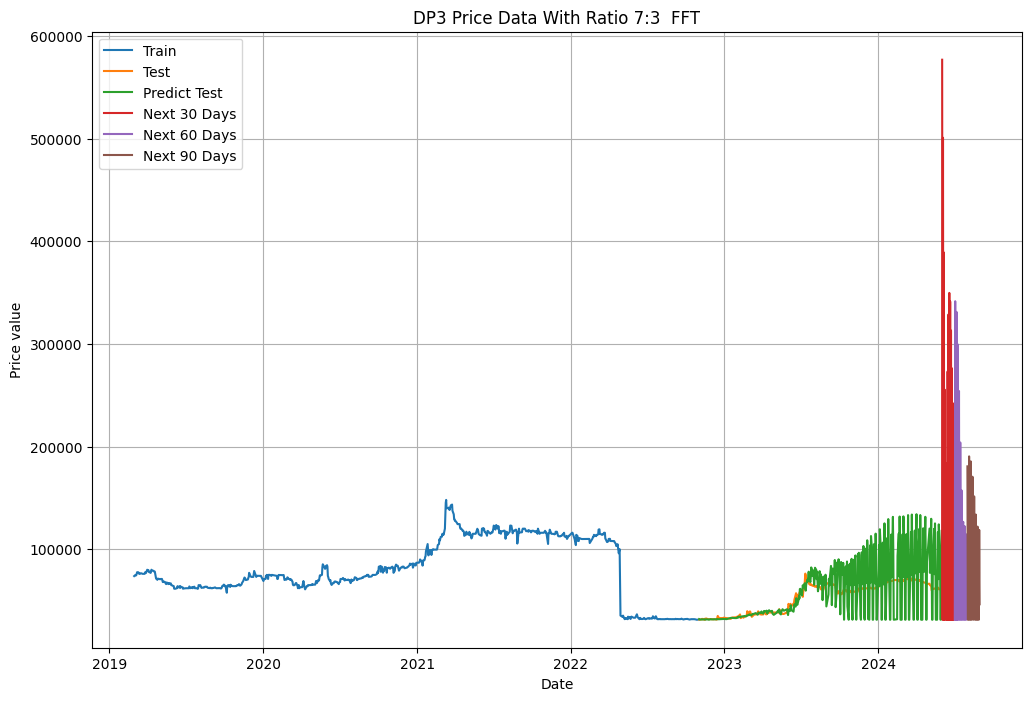

In [16]:
# Create DataFrames for plotting
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), index=df.index[:train_size], columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), index=df.index[train_size:], columns=['Price'])
filtered_test_df = pd.DataFrame(filtered_test, index=df.index[train_size:train_size+len(filtered_test)], columns=['Predict Test'])
next_30_days_df = pd.DataFrame(y_next_30_days, index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), columns=['Next 30 Days'])
next_60_days_df = pd.DataFrame(y_next_60_days[30:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=31), periods=30), columns=['Next 60 Days'])
next_90_days_df = pd.DataFrame(y_next_90_days[60:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=61), periods=30), columns=['Next 90 Days'])

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(train_data_df.index, train_data_df['Price'], label='Train')
plt.plot(test_data_df.index, test_data_df['Price'], label='Test')
plt.plot(filtered_test_df.index, filtered_test_df['Predict Test'], label='Predict Test')
plt.plot(next_30_days_df.index, next_30_days_df['Next 30 Days'], label='Next 30 Days')
plt.plot(next_60_days_df.index, next_60_days_df['Next 60 Days'], label='Next 60 Days')
plt.plot(next_90_days_df.index, next_90_days_df['Next 90 Days'], label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("DP3 Price Data With Ratio 7:3  FFT")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('FFT_73_DP3.png')
plt.show()

## Model 8:2

In [17]:
# Load and preprocess data
data = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\DP3 Historical Data.csv')
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [18]:
# Select 'Price' column and handle missing values
price_data = df['Price'].astype(float).interpolate()

In [19]:
# Remove outliers (simple Z-score method)
z_scores = np.abs((price_data - price_data.mean()) / price_data.std())
price_data = price_data[z_scores < 3]

In [20]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(price_data.values.reshape(-1, 1))

In [21]:
# Split data
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [22]:
# Perform FFT with windowing
def fft_transform(data, num_frequencies=10):
    n = len(data)
    window = hann(n)
    fft_result = fft(data * window)
    frequencies = np.fft.fftfreq(n)
    
    # Keep only top frequencies
    top_indices = np.argsort(np.abs(fft_result))[-num_frequencies:]
    filtered_fft = np.zeros_like(fft_result)
    filtered_fft[top_indices] = fft_result[top_indices]
    
    return filtered_fft, frequencies


In [23]:
# Inverse FFT
def ifft_transform(fft_result):
    return np.real(ifft(fft_result))

In [24]:
# Modify predict_with_trend function
def predict_with_trend(data, fft_result, days, window_size=30):
    # Linear trend
    x = np.arange(window_size)
    trend = np.polyfit(x, data[-window_size:].flatten(), 1)
    trend_func = np.poly1d(trend)
    
    # FFT prediction
    n = len(data)
    if len(fft_result) != n:
        fft_result, _ = fft_transform(data.flatten(), num_frequencies=best_num_freq)
    
    extended_fft = np.zeros(window_size + days, dtype=complex)
    extended_fft[:window_size] = fft_result[-window_size:]
    fft_pred = ifft_transform(extended_fft)[-days:]
    
    # Combine trend and FFT
    trend_pred = trend_func(np.arange(window_size, window_size+days))
    combined_pred = trend_pred + fft_pred
    return np.maximum(combined_pred, 0)  # Ensure non-negative values

In [25]:
# Optimize number of frequencies
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_num_freq = 0

for num_freq in range(5, 51, 5):
    mse_scores = []
    for train_index, val_index in tscv.split(train_data):
        train_subset = train_data[train_index]
        val_subset = train_data[val_index]
        
        train_fft, _ = fft_transform(train_subset.flatten(), num_frequencies=num_freq)
        pred = predict_with_trend(train_subset, train_fft, len(val_subset))
        mse = mean_squared_error(val_subset, pred)
        mse_scores.append(mse)
    
    avg_mse = np.mean(mse_scores)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_num_freq = num_freq

print(f"Best number of frequencies: {best_num_freq}")


Best number of frequencies: 5


In [26]:
# Recompute FFT with best number of frequencies
train_fft, _ = fft_transform(train_data.flatten(), num_frequencies=best_num_freq)

In [27]:
# Predict for test data using sliding window
window_size = 30
step_size = 7
filtered_test = []

for i in range(0, len(test_data), step_size):
    if i + window_size > len(train_data):
        break
    window_data = np.concatenate((train_data[-window_size:], test_data[:i]))
    window_fft, _ = fft_transform(window_data.flatten(), num_frequencies=best_num_freq)
    pred = predict_with_trend(window_data, window_fft, step_size, window_size)
    filtered_test.extend(pred)

filtered_test = np.array(filtered_test)[:len(test_data)]

In [28]:
# Predict future values
future_data = np.concatenate((train_data, test_data))
future_fft, _ = fft_transform(future_data.flatten(), num_frequencies=best_num_freq)
y_next_30_days = predict_with_trend(future_data, future_fft, 30, window_size)
y_next_60_days = predict_with_trend(future_data, future_fft, 60, window_size)
y_next_90_days = predict_with_trend(future_data, future_fft, 90, window_size)

In [29]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(test_data, filtered_test.reshape(-1, 1))
test_mse = mean_squared_error(test_data, filtered_test.reshape(-1, 1))
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_data, filtered_test.reshape(-1, 1))

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 0.5918705949551627
RMSE on Test set: 0.19870627622703738
MSLE on Test set: 0.022408821620275885


In [30]:
# Inverse transform predictions
filtered_test = scaler.inverse_transform(filtered_test.reshape(-1, 1)).flatten()
y_next_30_days = scaler.inverse_transform(y_next_30_days.reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(y_next_60_days.reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(y_next_90_days.reshape(-1, 1)).flatten()

# Print predictions
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)

Predicted next 30 days:
[576740.2391666   31310.         500746.84731884  31310.
 389006.4881942   31310.         255369.05881975  31310.
 115929.22345233  65175.916097    31310.         183303.91351553
  31310.         273120.97596835  31310.         328628.88221188
  31310.         349621.26785614  31310.         341305.01539759
  31310.         313009.89211809  31310.         276226.59800965
  31310.         242327.7051354   31310.         220378.32987946
  31310.         215424.83483657]

Predicted next 60 days:
[218132.93972511  31310.         181059.36446332 300863.6710821
  31310.          88348.65792952 367745.134736    31310.
  31310.         409893.79664837  31310.          31310.
 421441.97943416  31310.          31310.         400484.60636072
  31310.          31310.         349398.83752785 120128.16524679
  31310.         274481.75717705 210209.36045433  31310.
 184966.62999305 280676.97019436  31310.          91583.23214706
 325244.66512211  31310.          31310.        

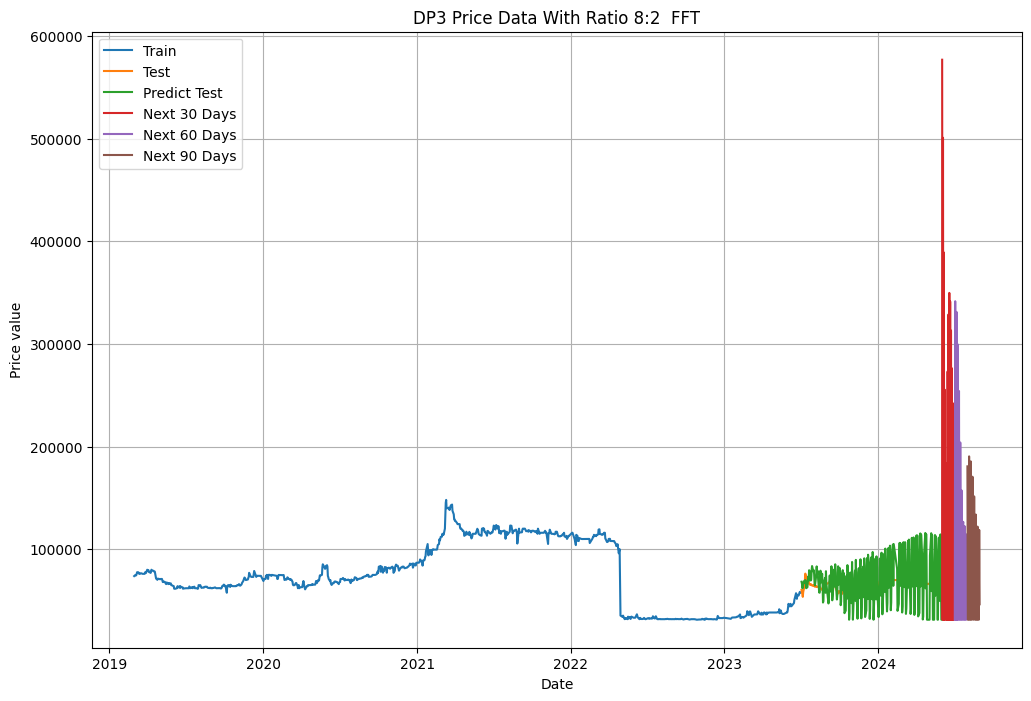

In [31]:
# Create DataFrames for plotting
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), index=df.index[:train_size], columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), index=df.index[train_size:], columns=['Price'])
filtered_test_df = pd.DataFrame(filtered_test, index=df.index[train_size:train_size+len(filtered_test)], columns=['Predict Test'])
next_30_days_df = pd.DataFrame(y_next_30_days, index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), columns=['Next 30 Days'])
next_60_days_df = pd.DataFrame(y_next_60_days[30:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=31), periods=30), columns=['Next 60 Days'])
next_90_days_df = pd.DataFrame(y_next_90_days[60:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=61), periods=30), columns=['Next 90 Days'])

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(train_data_df.index, train_data_df['Price'], label='Train')
plt.plot(test_data_df.index, test_data_df['Price'], label='Test')
plt.plot(filtered_test_df.index, filtered_test_df['Predict Test'], label='Predict Test')
plt.plot(next_30_days_df.index, next_30_days_df['Next 30 Days'], label='Next 30 Days')
plt.plot(next_60_days_df.index, next_60_days_df['Next 60 Days'], label='Next 60 Days')
plt.plot(next_90_days_df.index, next_90_days_df['Next 90 Days'], label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("DP3 Price Data With Ratio 8:2  FFT")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('FFT_82_DP3.png')
plt.show()

## Model 9:1

In [32]:
# Load and preprocess data
data = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\DP3 Historical Data.csv')
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [33]:
# Select 'Price' column and handle missing values
price_data = df['Price'].astype(float).interpolate()

In [34]:
# Remove outliers (simple Z-score method)
z_scores = np.abs((price_data - price_data.mean()) / price_data.std())
price_data = price_data[z_scores < 3]

In [35]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(price_data.values.reshape(-1, 1))

In [36]:
# Split data
train_size = int(len(data_scaled) * 0.9)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [37]:
# Perform FFT with windowing
def fft_transform(data, num_frequencies=10):
    n = len(data)
    window = hann(n)
    fft_result = fft(data * window)
    frequencies = np.fft.fftfreq(n)
    
    # Keep only top frequencies
    top_indices = np.argsort(np.abs(fft_result))[-num_frequencies:]
    filtered_fft = np.zeros_like(fft_result)
    filtered_fft[top_indices] = fft_result[top_indices]
    
    return filtered_fft, frequencies


In [38]:
# Inverse FFT
def ifft_transform(fft_result):
    return np.real(ifft(fft_result))

In [39]:
# Modify predict_with_trend function
def predict_with_trend(data, fft_result, days, window_size=30):
    # Linear trend
    x = np.arange(window_size)
    trend = np.polyfit(x, data[-window_size:].flatten(), 1)
    trend_func = np.poly1d(trend)
    
    # FFT prediction
    n = len(data)
    if len(fft_result) != n:
        fft_result, _ = fft_transform(data.flatten(), num_frequencies=best_num_freq)
    
    extended_fft = np.zeros(window_size + days, dtype=complex)
    extended_fft[:window_size] = fft_result[-window_size:]
    fft_pred = ifft_transform(extended_fft)[-days:]
    
    # Combine trend and FFT
    trend_pred = trend_func(np.arange(window_size, window_size+days))
    combined_pred = trend_pred + fft_pred
    return np.maximum(combined_pred, 0)  # Ensure non-negative values

In [40]:
# Optimize number of frequencies
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_num_freq = 0

for num_freq in range(5, 51, 5):
    mse_scores = []
    for train_index, val_index in tscv.split(train_data):
        train_subset = train_data[train_index]
        val_subset = train_data[val_index]
        
        train_fft, _ = fft_transform(train_subset.flatten(), num_frequencies=num_freq)
        pred = predict_with_trend(train_subset, train_fft, len(val_subset))
        mse = mean_squared_error(val_subset, pred)
        mse_scores.append(mse)
    
    avg_mse = np.mean(mse_scores)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_num_freq = num_freq

print(f"Best number of frequencies: {best_num_freq}")


Best number of frequencies: 5


In [41]:
# Recompute FFT with best number of frequencies
train_fft, _ = fft_transform(train_data.flatten(), num_frequencies=best_num_freq)

In [42]:
# Predict for test data using sliding window
window_size = 30
step_size = 7
filtered_test = []

for i in range(0, len(test_data), step_size):
    if i + window_size > len(train_data):
        break
    window_data = np.concatenate((train_data[-window_size:], test_data[:i]))
    window_fft, _ = fft_transform(window_data.flatten(), num_frequencies=best_num_freq)
    pred = predict_with_trend(window_data, window_fft, step_size, window_size)
    filtered_test.extend(pred)

filtered_test = np.array(filtered_test)[:len(test_data)]

In [43]:
# Predict future values
future_data = np.concatenate((train_data, test_data))
future_fft, _ = fft_transform(future_data.flatten(), num_frequencies=best_num_freq)
y_next_30_days = predict_with_trend(future_data, future_fft, 30, window_size)
y_next_60_days = predict_with_trend(future_data, future_fft, 60, window_size)
y_next_90_days = predict_with_trend(future_data, future_fft, 90, window_size)

In [44]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(test_data, filtered_test.reshape(-1, 1))
test_mse = mean_squared_error(test_data, filtered_test.reshape(-1, 1))
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_data, filtered_test.reshape(-1, 1))

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 0.3786914198624385
RMSE on Test set: 0.13524681107805764
MSLE on Test set: 0.010364941136088867


In [45]:
# Inverse transform predictions
filtered_test = scaler.inverse_transform(filtered_test.reshape(-1, 1)).flatten()
y_next_30_days = scaler.inverse_transform(y_next_30_days.reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(y_next_60_days.reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(y_next_90_days.reshape(-1, 1)).flatten()

# Print predictions
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)

Predicted next 30 days:
[576740.2391666   31310.         500746.84731884  31310.
 389006.4881942   31310.         255369.05881975  31310.
 115929.22345233  65175.916097    31310.         183303.91351553
  31310.         273120.97596835  31310.         328628.88221188
  31310.         349621.26785614  31310.         341305.01539759
  31310.         313009.89211809  31310.         276226.59800965
  31310.         242327.7051354   31310.         220378.32987946
  31310.         215424.83483657]

Predicted next 60 days:
[218132.93972511  31310.         181059.36446332 300863.6710821
  31310.          88348.65792952 367745.134736    31310.
  31310.         409893.79664837  31310.          31310.
 421441.97943416  31310.          31310.         400484.60636072
  31310.          31310.         349398.83752785 120128.16524679
  31310.         274481.75717705 210209.36045433  31310.
 184966.62999305 280676.97019436  31310.          91583.23214706
 325244.66512211  31310.          31310.        

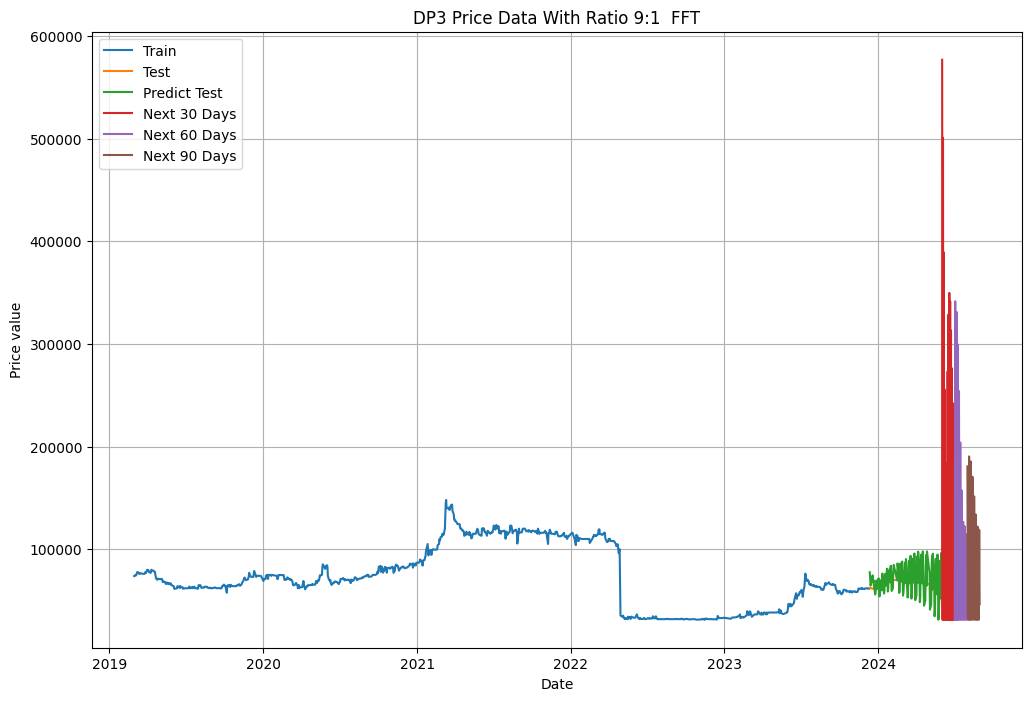

In [46]:
# Create DataFrames for plotting
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), index=df.index[:train_size], columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), index=df.index[train_size:], columns=['Price'])
filtered_test_df = pd.DataFrame(filtered_test, index=df.index[train_size:train_size+len(filtered_test)], columns=['Predict Test'])
next_30_days_df = pd.DataFrame(y_next_30_days, index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), columns=['Next 30 Days'])
next_60_days_df = pd.DataFrame(y_next_60_days[30:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=31), periods=30), columns=['Next 60 Days'])
next_90_days_df = pd.DataFrame(y_next_90_days[60:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=61), periods=30), columns=['Next 90 Days'])

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(train_data_df.index, train_data_df['Price'], label='Train')
plt.plot(test_data_df.index, test_data_df['Price'], label='Test')
plt.plot(filtered_test_df.index, filtered_test_df['Predict Test'], label='Predict Test')
plt.plot(next_30_days_df.index, next_30_days_df['Next 30 Days'], label='Next 30 Days')
plt.plot(next_60_days_df.index, next_60_days_df['Next 60 Days'], label='Next 60 Days')
plt.plot(next_90_days_df.index, next_90_days_df['Next 90 Days'], label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("DP3 Price Data With Ratio 9:1  FFT")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('FFT_91_DP3.png')
plt.show()